In [53]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, 
    TimeSeriesSplit, validation_curve
)
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier

from scipy import sparse

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
%config InlineBackend.figure_format = 'retina'

In [3]:
Dtrain = pd.read_csv('../Amazon_Review_commons/Dtrain.csv')
Dtest = pd.read_csv('../Amazon_Review_commons/Dtest.csv')

In [50]:
cunt = joblib.load('../Amazon_Review_commons/countVectorizer.model')

In [4]:
def get_summary_grid(grid):
    parms = list(grid.param_grid.keys())
    columns = ['Iter #']
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in grid.param_grid.keys():
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[1:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
    for k, v in grid.param_grid.items():
        items *= len(v)
    df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [5]:
def get_summary_randomized(grid):
    parms = list(grid.param_distributions.keys())
    columns = []
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in parms:
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[0:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
#     for k, v in grid.param_distributions.items():
#         items *= len(v)
#     df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [16]:
tscv = TimeSeriesSplit(n_splits=5)

## Bag of Words

### Loading the data

In [7]:
Dtrain_bow = sparse.load_npz('../Amazon_Review_commons/BOW_train.npz')
Dtest_bow = sparse.load_npz('../Amazon_Review_commons/BOW_test.npz')

In [8]:
yTrain_bow = Dtrain.Polarity
yTest_bow = Dtest.Polarity

### GridSearch 1

In [13]:
estimator = DecisionTreeClassifier(random_state=42)

In [22]:
params = {
    'max_depth': [*range(2, 11)],
    'min_samples_split': [*range(2, 200, 50)]
}

In [23]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [24]:
features = Dtrain_bow
labels = yTrain_bow.apply(lambda x: 1 if x == 'positive' else 0).values

In [25]:
grid.fit(features, labels)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=2, min_samples_split=2 ................................
[CV] max_depth=2, min_samples_split=2 ................................
[CV] max_depth=2, min_samples_split=2 ................................
[CV] max_depth=2, min_samples_split=2 ................................
[CV] max_depth=2, min_samples_split=2 ................................
[CV] max_depth=2, min_samples_split=52 ...............................
[CV] max_depth=2, min_samples_split=52 ...............................
[CV] max_depth=2, min_samples_split=52 ...............................
[CV] ................. max_depth=2, min_samples_split=2, total=   1.3s
[CV] max_depth=2, min_samples_split=52 ...............................
[CV] ................ max_depth=2, min_samples_split=52, total=   2.1s
[CV] max_depth=2, min_samples_split=52 ...............................
[CV] ................. max_depth=2, min_samples_split=2, total=   3.4s
[CV] max_depth=

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   26.4s


[CV] max_depth=3, min_samples_split=102 ..............................
[CV] ................ max_depth=3, min_samples_split=52, total=   6.6s
[CV] max_depth=3, min_samples_split=102 ..............................
[CV] ................. max_depth=3, min_samples_split=2, total=  10.9s
[CV] max_depth=3, min_samples_split=152 ..............................
[CV] ............... max_depth=3, min_samples_split=102, total=   4.3s
[CV] max_depth=3, min_samples_split=152 ..............................
[CV] ............... max_depth=3, min_samples_split=152, total=   1.8s
[CV] max_depth=3, min_samples_split=152 ..............................
[CV] ................ max_depth=3, min_samples_split=52, total=  10.3s
[CV] ................. max_depth=3, min_samples_split=2, total=  13.6s
[CV] max_depth=3, min_samples_split=152 ..............................
[CV] max_depth=3, min_samples_split=152 ..............................
[CV] ............... max_depth=3, min_samples_split=152, total=   3.8s
[CV] .

[CV] max_depth=6, min_samples_split=102 ..............................
[CV] ............... max_depth=6, min_samples_split=102, total=   1.8s
[CV] max_depth=6, min_samples_split=102 ..............................
[CV] ............... max_depth=5, min_samples_split=152, total=  15.5s
[CV] max_depth=6, min_samples_split=102 ..............................
[CV] ................. max_depth=6, min_samples_split=2, total=  11.8s
[CV] max_depth=6, min_samples_split=102 ..............................
[CV] ............... max_depth=6, min_samples_split=102, total=   4.1s
[CV] max_depth=6, min_samples_split=152 ..............................
[CV] ................ max_depth=6, min_samples_split=52, total=   8.8s
[CV] max_depth=6, min_samples_split=152 ..............................
[CV] ............... max_depth=6, min_samples_split=152, total=   1.9s
[CV] max_depth=6, min_samples_split=152 ..............................
[CV] ................ max_depth=6, min_samples_split=52, total=  10.7s
[CV] m

[CV] max_depth=9, min_samples_split=52 ...............................
[CV] ............... max_depth=8, min_samples_split=152, total=  11.9s
[CV] max_depth=9, min_samples_split=102 ..............................
[CV] ............... max_depth=8, min_samples_split=102, total=  19.3s
[CV] max_depth=9, min_samples_split=102 ..............................
[CV] ............... max_depth=9, min_samples_split=102, total=   2.7s
[CV] max_depth=9, min_samples_split=102 ..............................
[CV] ............... max_depth=8, min_samples_split=152, total=  17.5s
[CV] max_depth=9, min_samples_split=102 ..............................


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.8min


[CV] ............... max_depth=9, min_samples_split=102, total=   4.5s
[CV] max_depth=9, min_samples_split=102 ..............................
[CV] ................ max_depth=9, min_samples_split=52, total=   9.4s
[CV] max_depth=9, min_samples_split=152 ..............................
[CV] ................. max_depth=9, min_samples_split=2, total=  15.0s
[CV] max_depth=9, min_samples_split=152 ..............................
[CV] ............... max_depth=9, min_samples_split=152, total=   2.1s
[CV] max_depth=9, min_samples_split=152 ..............................
[CV] ............... max_depth=9, min_samples_split=102, total=   8.5s
[CV] max_depth=9, min_samples_split=152 ..............................
[CV] ................ max_depth=9, min_samples_split=52, total=  13.7s
[CV] max_depth=9, min_samples_split=152 ..............................
[CV] ............... max_depth=9, min_samples_split=152, total=   5.5s
[CV] max_depth=10, min_samples_split=2 ...............................
[CV] .

[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:  3.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 52, 102, 152]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'precision', 'f1', 'accuracy', 'recall'}, verbose=2)

In [26]:
grid_res = get_summary_grid(grid)
grid_res.sort_values('test_f1', ascending=False).head()

,Iter #,train_precision,test_precision,train_f1,test_f1,train_accuracy,test_accuracy,train_recall,test_recall,fit_time,score_time,max_depth,min_samples_split
27,28,0.885966,0.860643,0.936483,0.921225,0.882681,0.857269,0.993184,0.991106,8.658232,0.184822,8,152
35,36,0.886740,0.860924,0.936925,0.921210,0.883542,0.857288,0.993224,0.990720,7.951654,0.126433,10,152
32,33,0.888231,0.861252,0.938020,0.921204,0.885640,0.857349,0.993809,0.990253,11.145265,0.220282,10,2
24,25,0.886753,0.860763,0.937122,0.921188,0.883894,0.857236,0.993632,0.990854,9.002700,0.161932,8,2
33,34,0.887428,0.861118,0.937417,0.921174,0.884494,0.857274,0.993457,0.990359,9.769030,0.158716,10,52


In [27]:
grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=152,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### How F1 score changes as ```max_depth``` increases?

In [32]:
sns.set_style("whitegrid")
grid_res.rename({'min_samples_split': 'min_samples'}, axis=1, inplace=True)

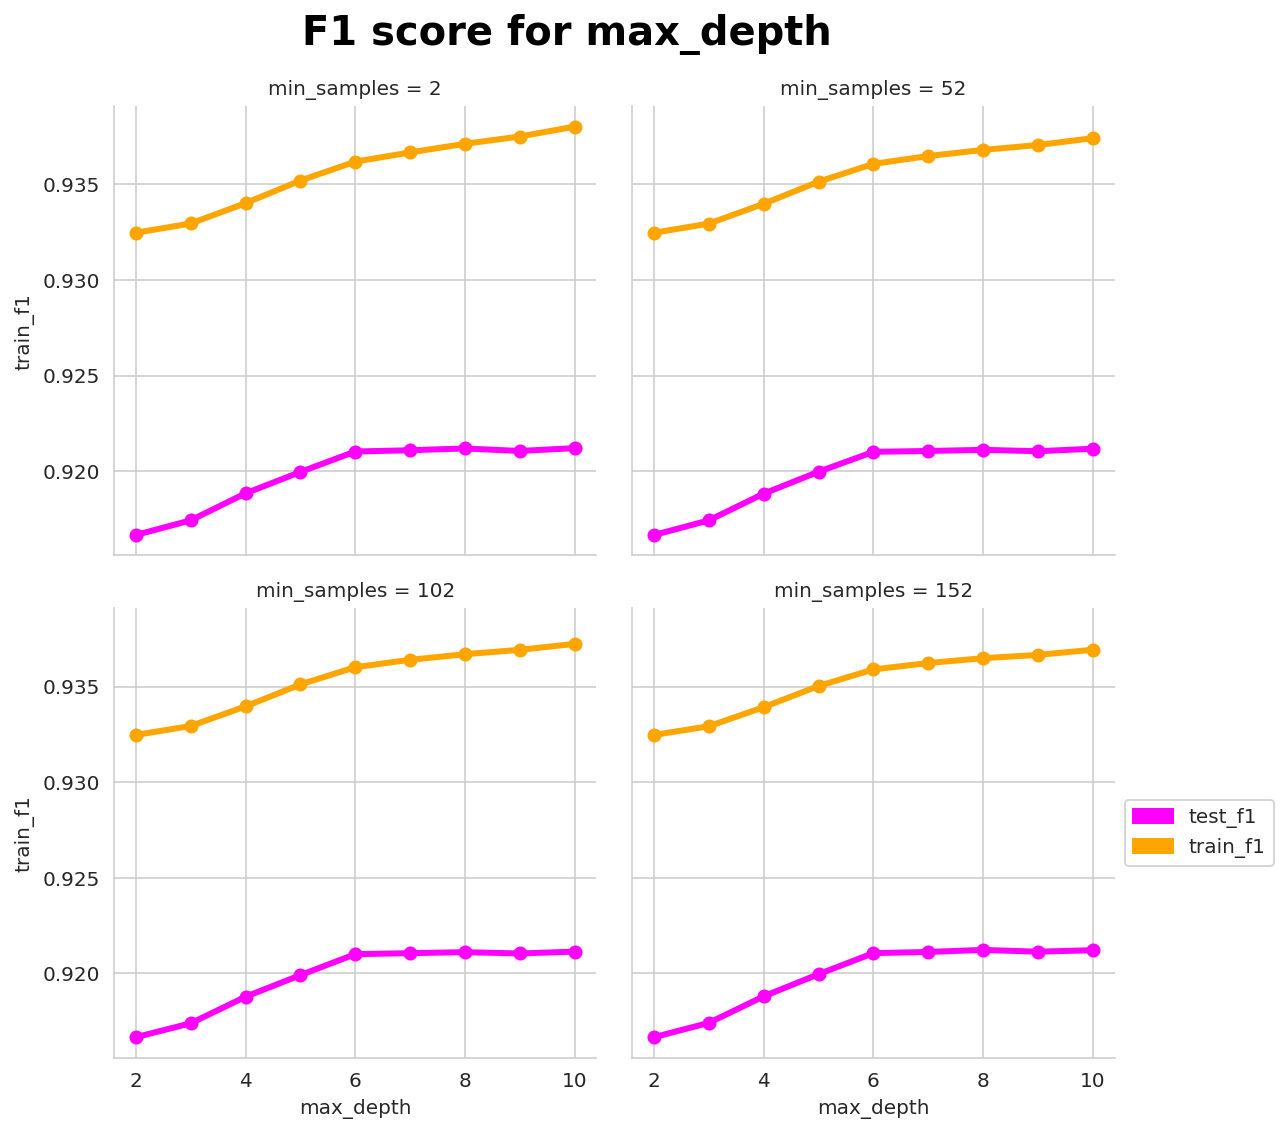

In [36]:
g = sns.FacetGrid(grid_res, col="min_samples", col_wrap=2, height=4)
g = g.map(plt.plot, "max_depth", "test_f1", marker="o", color='magenta', linewidth=3)
g = g.map(plt.plot, "max_depth", "train_f1", marker="o", color='orange', linewidth=3)
# legend_labels  = ['test_f1', 'train_f1']
# plt.legend(handles=legend_patches)
legend_patches = [matplotlib.patches.Patch(color='magenta', label='test_f1'),
                 matplotlib.patches.Patch(color='orange', label='train_f1')]
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1,0.5))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('F1 score for max_depth', size=20, weight='bold', color='black');

### GridSearch 2

In [37]:
estimator = grid.best_estimator_

In [38]:
params = {
    'min_samples_leaf': [*range(2, 11)],
    'splitter': ['random', 'best']
}

In [39]:
grid2 = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [40]:
grid2.fit(features, labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] min_samples_leaf=2, splitter=random .............................
[CV] min_samples_leaf=2, splitter=random .............................
[CV] min_samples_leaf=2, splitter=random .............................
[CV] min_samples_leaf=2, splitter=random .............................
[CV] min_samples_leaf=2, splitter=random .............................
[CV] min_samples_leaf=2, splitter=best ...............................
[CV] min_samples_leaf=2, splitter=best ...............................
[CV] min_samples_leaf=2, splitter=best ...............................
[CV] .............. min_samples_leaf=2, splitter=random, total=   1.9s
[CV] min_samples_leaf=2, splitter=best ...............................
[CV] ................ min_samples_leaf=2, splitter=best, total=   2.3s
[CV] min_samples_leaf=2, splitter=best ...............................
[CV] .............. min_samples_leaf=2, splitter=random, total=   4.2s
[CV] min_samples

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   31.8s


[CV] ................ min_samples_leaf=3, splitter=best, total=  16.1s
[CV] min_samples_leaf=5, splitter=random .............................
[CV] ................ min_samples_leaf=4, splitter=best, total=   8.3s
[CV] min_samples_leaf=5, splitter=random .............................
[CV] .............. min_samples_leaf=5, splitter=random, total=   4.3s
[CV] min_samples_leaf=5, splitter=best ...............................
[CV] .............. min_samples_leaf=4, splitter=random, total=  13.0s
[CV] min_samples_leaf=5, splitter=best ...............................
[CV] ................ min_samples_leaf=5, splitter=best, total=   1.8s
[CV] min_samples_leaf=5, splitter=best ...............................
[CV] ................ min_samples_leaf=5, splitter=best, total=   3.8s
[CV] min_samples_leaf=5, splitter=best ...............................
[CV] ................ min_samples_leaf=4, splitter=best, total=  12.1s
[CV] min_samples_leaf=5, splitter=best ...............................
[CV] .

[CV] ............... min_samples_leaf=10, splitter=best, total=   7.5s
[CV] ................ min_samples_leaf=9, splitter=best, total=  16.7s
[CV] ............. min_samples_leaf=10, splitter=random, total=  12.1s
[CV] ............. min_samples_leaf=10, splitter=random, total=  15.5s
[CV] ............... min_samples_leaf=10, splitter=best, total=  10.9s
[CV] ............... min_samples_leaf=10, splitter=best, total=  13.7s


[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:  1.9min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=152,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'splitter': ['random', 'best']},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'precision', 'f1', 'accuracy', 'recall'}, verbose=2)

In [41]:
grid_res2 = get_summary_grid(grid2)
grid_res2.sort_values('test_f1', ascending=False).head()

,Iter #,train_precision,test_precision,train_f1,test_f1,train_accuracy,test_accuracy,train_recall,test_recall,fit_time,score_time,min_samples_leaf,splitter
14,15,0.885847,0.860590,0.936361,0.921223,0.882457,0.857260,0.993057,0.991161,8.609246,0.276211,9,random
1,2,0.885965,0.860642,0.936478,0.921222,0.882672,0.857265,0.993174,0.991100,8.406722,0.160808,2,best
15,16,0.885847,0.860594,0.936361,0.921222,0.882457,0.857260,0.993057,0.991156,8.506877,0.178972,9,best
12,13,0.885866,0.860587,0.936381,0.921211,0.882494,0.857241,0.993079,0.991138,9.006253,0.183299,8,random
10,11,0.885901,0.860590,0.936398,0.921211,0.882529,0.857241,0.993073,0.991133,8.706900,0.154113,7,random


In [42]:
grid2.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=152,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random')

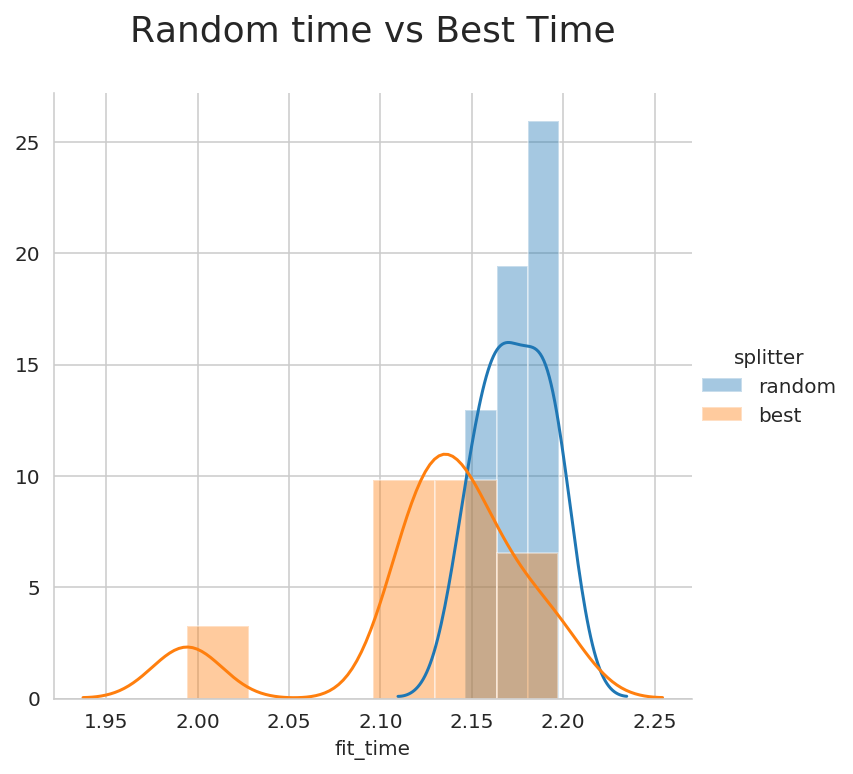

In [44]:
grid_res2['fit_time'] = np.log(grid_res2['fit_time'])
sns.FacetGrid(grid_res2, hue='splitter', height=5).map(sns.distplot, 'fit_time').add_legend();
plt.title('Random time vs Best Time\n', fontsize=18);

In [45]:
joblib.dump(grid2.best_estimator_, 'bow_best.model')

['bow_best.model']

### Feature Imporrance

In [46]:
def get_top_n_features(n, weights, typ='+'):
    if typ == '+':
        INDEX_topW = weights.argsort()[::-1][0:n]
    elif typ == '-':
        INDEX_topW = weights.argsort()[0:n]
    topW = weights[INDEX_topW]
    featureNames = np.array(cunt.get_feature_names())
    return pd.DataFrame({'features': featureNames[INDEX_topW],
 'score': topW})

In [47]:
clf = joblib.load('bow_best.model')

In [51]:
fimp = get_top_n_features(n=20, weights=clf.feature_importances_)

In [55]:
plt.rcParams['figure.figsize'] = [10, 6]

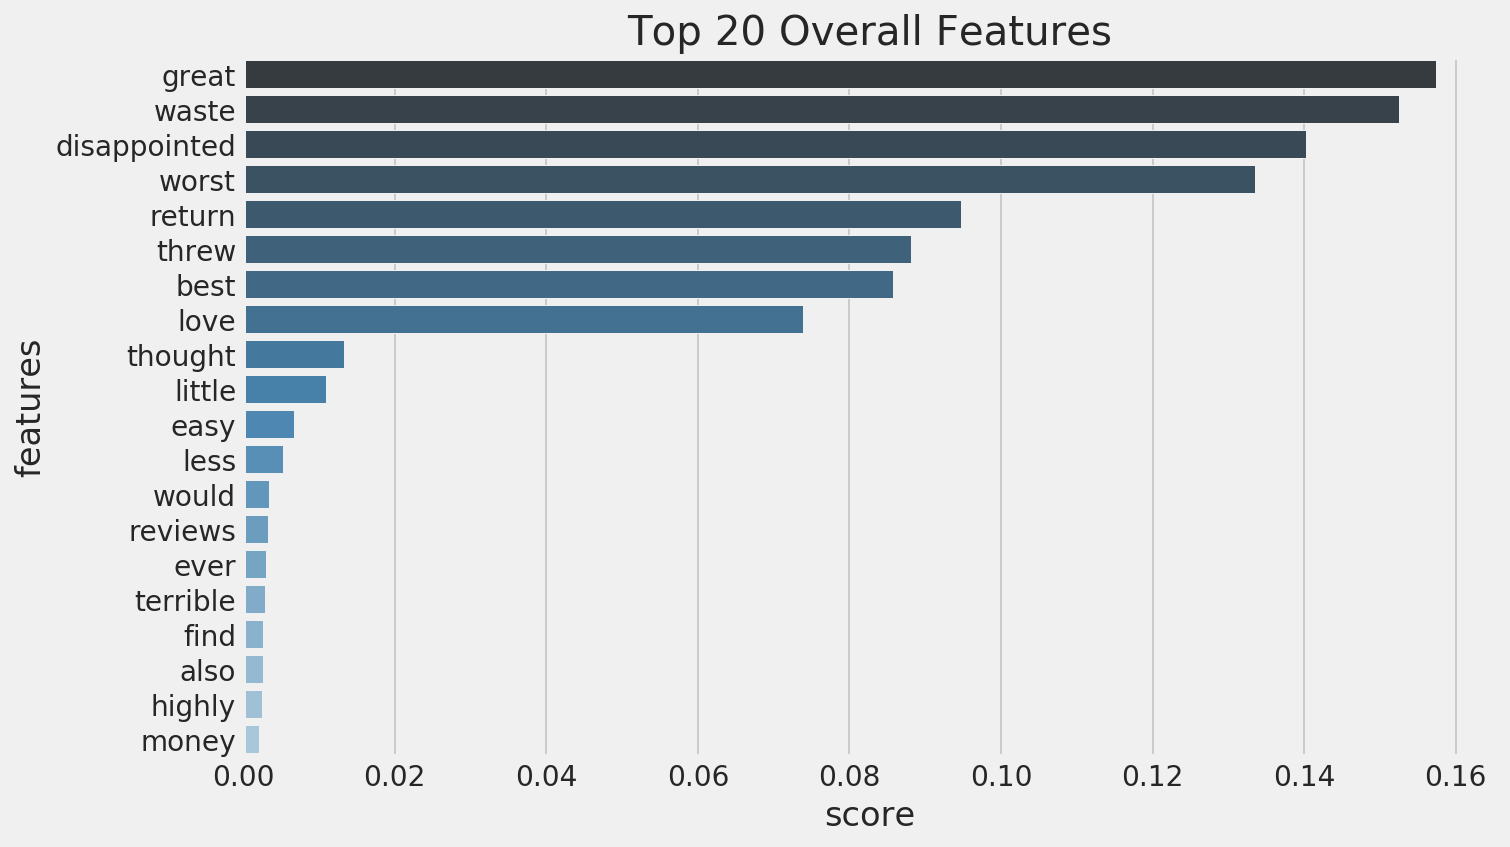

In [56]:
plt.style.use('fivethirtyeight')
sns.barplot(y='features', x='score', data=fimp, palette='Blues_d');
plt.title('Top 20 Overall Features');

## F1 score on the test data

In [60]:
xTest_bow = Dtest_bow
actuals_bow = yTest_bow.apply(lambda x: 1 if x == 'positive' else 0).values

In [61]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [62]:
preds_bow = clf.predict(xTest_bow)

In [64]:
acs_bow = accuracy_score(actuals_bow, preds_bow)
pre_bow = precision_score(actuals_bow, preds_bow)
rec_bow = recall_score(actuals_bow, preds_bow)
f1_bow = f1_score(actuals_bow, preds_bow)

In [65]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorization', 'Accuracy', 'Precision', 'Recall', 'F1']
x.add_row(['BOW', acs_bow, pre_bow, rec_bow, f1_bow])
print(x)

+---------------+--------------------+--------------------+--------------------+--------------------+
| Vectorization |      Accuracy      |     Precision      |       Recall       |         F1         |
+---------------+--------------------+--------------------+--------------------+--------------------+
|      BOW      | 0.8432568017869567 | 0.8456667423898228 | 0.9909383318544809 | 0.9125571988887073 |
+---------------+--------------------+--------------------+--------------------+--------------------+
